# Conformalized Early Stopping -- Regression

- We implement the conformalized early stopping algorithm as well as the benchmark methods on the bike sharing demand dataset provided by Hadi Fanaee Tork from Capital Bikeshare and hosted by the UCI Machine Learning Repository [1]. 

**Note: the following dataset description is copied from UCI Machine Learning Repository. **
Bike sharing systems are new generation of traditional bike rentals where whole process from membership, rental and return back has become automatic. Through these systems, user is able to easily rent a bike from a particular position and return back at another position. Currently, there are about over 500 bike-sharing programs around the world which is composed of over 500 thousands bicycles. Today, there exists great interest in these systems due to their important role in traffic, environmental and health issues. 

Apart from interesting real world applications of bike sharing systems, the characteristics of data being generated by these systems make them attractive for the research. Opposed to other transport services such as bus or subway, the duration of travel, departure and arrival position is explicitly recorded in these systems. This feature turns bike sharing system into a virtual sensor network that can be used for sensing mobility in the city. Hence, it is expected that most of important events in the city could be detected via monitoring these data.

- We follow the data cleaning process and used the same model architecture as in the conformalized quantile regression experiments https://github.com/yromano/cqr/tree/master/datasets [2]. To be specific, we standardize the features to have zero mean and unit variance and we rescale the response by dividing it by its mean absolute value

- For the benchmark methods, we randomly selected 2000 samples for training the deep neural network models, 1000 validation samples to decide the early stopped models, and additional 1000 samples for calibration. For the conformalized early stopping method, we use the same subset of selected samples but merge the training and validation samples and use the merged dataset for training. The 1000 calibration samples are used together with new test point to select the best models. For both benchmark and our proposed method, we train the model for  𝑇max=200  epochs, saving every snapshot, and compute the marginal coverage rate and size of the prediction intervals averaged over 100 test samples.

[1] Fanaee-T, Hadi, and Gama, Joao, Event labeling combining ensemble detectors and background knowledge, Progress in Artificial Intelligence (2013): pp. 1-15, Springer Berlin Heidelberg.

[2] Yaniv Romano, Evan Patterson, Emmanuel J. Candès, Conformalized Quantile Regression, Advances in Neural Information Processing Systems (2019), https://proceedings.neurips.cc/paper/2019/file/5103c3584b063c431bd1268e9b5e76fb-Paper.pdf

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [8]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time

import torch as th
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import StandardScaler
from sympy import *
import pathlib
import pdb
import matplotlib.pyplot as plt

from method import CES_regression
from networks import mse_model, MSE_loss
from inference import Conformal_PI

In [9]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [250,159,181]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

def plot_loss(train_loss, val_loss):
    x = np.arange(1, len(train_loss) + 1)

    plt.figure()
    plt.plot(x, train_loss, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_loss, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training, validation and test loss")
    
    plt.show()

## Loading and cleaning the dataset

In [3]:
reload_dataset = False

In [4]:
if reload_dataset:
  !git clone https://github.com/yromano/cqr.git

In [10]:
from cqr.datasets import datasets

class PrepareData(Dataset):

    def __init__(self, X, y, scale_X=False):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
                self.X = torch.from_numpy(X)
            self.X = torch.from_numpy(X)
        if not torch.is_tensor(y):
            self.y = torch.from_numpy(y)
        

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx].float(), self.y[idx].float()


## Training and evaluating the benchmark methods

In [81]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 2000
n_val = 1000
n_cal = 1000
n_test = 100 

seed = 23333
np.random.seed(seed)
th.manual_seed(seed)

idx = np.random.permutation(n_train+n_val+n_cal)
idx_test = np.random.permutation(n_test)

# divide the data into proper training set and calibration set
idx_train_BM, idx_val_BM, idx_cal_BM = idx[:n_train], idx[n_train:n_val+n_train], idx[n_val+n_train: n_val+n_train + n_cal]

# load the data
X, y = datasets.GetDataset('bike', './cqr/datasets/')

# split the dataset into disjoint subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train[idx_train_BM])
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test[idx_test])

# scale the response values by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train[idx_train_BM]))
y_train = np.squeeze(y_train)/mean_ytrain
y_test = np.squeeze(y_test[idx_test])/mean_ytrain

# reshape the data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# data splitting
X_train_BM, y_train_BM = X_train[idx_train_BM], y_train[idx_train_BM]
X_val_BM, y_val_BM = X_train[idx_val_BM], y_train[idx_val_BM]
X_cal_BM, y_cal_BM = X_train[idx_cal_BM], y_train[idx_cal_BM]

print("Size (BM): train (%d, %d), validation (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_BM.shape[0], X_train_BM.shape[1], X_val_BM.shape[0], X_val_BM.shape[1], 
       X_cal_BM.shape[0], X_cal_BM.shape[1], X_test.shape[0], X_test.shape[1]))
# sys.stdout.flush()

Size (BM): train (2000, 18), validation (1000, 18), calibration (1000, 18), test (100, 18)


In [82]:
# set model hyperparameter
batch_size = 64
in_shape = X_train_BM.shape[1]
hidden_layer_size = 256
dropout = 0
num_epochs = 200
lr = 0.0005
wd = 1e-5

num_workers = 0

In [83]:
train_loader = DataLoader(PrepareData(X_train_BM, y_train_BM, scale_X=False), batch_size=batch_size)
val_loader = DataLoader(PrepareData(X_val_BM, y_val_BM, scale_X=False), batch_size=batch_size, drop_last = True) 
calib_loader = DataLoader(PrepareData(X_cal_BM, y_cal_BM, scale_X=False), batch_size=1, shuffle = False, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

print("Dataloader size (BM): train (%d), validation (%d), calibration (%d), test (%d)" % \
      (len(train_loader), len(val_loader), len(calib_loader), len(test_loader)))

Dataloader size (BM): train (32), validation (15), calibration (1000), test (100)


In [84]:
# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size) #, dropout = dropout
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

BM_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=val_loader, criterion= MSE_loss, optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 200
learning_rate= 0.0005


In [85]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
BM_reg.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 200, 9% 	 train_loss: 2.09  took: 0.01s
Epoch 1 of 200, 18% 	 train_loss: 1.30  took: 0.01s
Epoch 1 of 200, 28% 	 train_loss: 0.85  took: 0.01s
Epoch 1 of 200, 37% 	 train_loss: 1.13  took: 0.01s
Epoch 1 of 200, 46% 	 train_loss: 0.87  took: 0.01s
Epoch 1 of 200, 56% 	 train_loss: 1.00  took: 0.01s
Epoch 1 of 200, 65% 	 train_loss: 0.90  took: 0.01s
Epoch 1 of 200, 75% 	 train_loss: 0.74  took: 0.01s
Epoch 1 of 200, 84% 	 train_loss: 0.63  took: 0.01s
Epoch 1 of 200, 93% 	 train_loss: 0.62  took: 0.01s
val_loss = 0.63
Snapshot saved at epoch 1.
Epoch 2 of 200, 9% 	 train_loss: 0.75  took: 0.01s
Epoch 2 of 200, 18% 	 train_loss: 0.57  took: 0.01s
Epoch 2 of 200, 28% 	 train_loss: 0.53  took: 0.01s
Epoch 2 of 200, 37% 	 train_loss: 0.59  took: 0.01s
Epoch 2 of 200, 46% 	 train_loss: 0.51  took: 0.01s
Epoch 2 of 200, 56% 	 train_loss: 0.64  took: 0.01s
Epoch 2 of 200, 65% 	 train_loss: 0.62  took: 0.01s
Epoch 2 of 200, 75% 	 train_loss: 0.53  took: 0.01s
Epoch 2 of 200, 84% 	 t

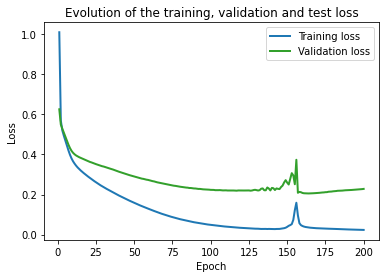

In [86]:
# plot the loss history
plot_loss(BM_reg.train_loss_history, BM_reg.val_loss_history)

In [87]:
# Check the benchmark models
bm_loss, bm_model, loss_history = BM_reg.select_model()

0.20532156030337015
./content/model163.pth


In [88]:
# Split conformal prediction 
alpha = 0.1

coverage_BM = []
size_BM = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # pi, cal_scores, test_pred, qhat = C_PI.benchmark_ICP(input, calib_loader, bm_model)
  benchmarkPI = C_PI.benchmark_ICP(input, bm_model)
  size_BM.append(benchmarkPI[0]._measure)
  coverage_BM.append(response in benchmarkPI[0])

100%|██████████| 100/100 [00:24<00:00,  4.02it/s]


In [89]:
print("The marginal coverage rate is (BM) {}".format(sum(coverage_BM)/len(coverage_BM)))
print("The average size is (BM) {}".format(sum(size_BM)/len(size_BM)))

The marginal coverage rate is (BM) 0.9
The average size is (BM) 1.43916225671768


## Conforamlized early stopping

In [61]:
# specify the number of samples in training, validation, calibration and test datasets
n_train = 2000
n_val = 1000
n_cal = 1000
n_test = 100 

seed = 233
np.random.seed(seed)
th.manual_seed(seed)
idx = np.random.permutation(n_train+n_val+n_cal)
idx_test = np.random.permutation(n_test)

# divide the data into proper training set and calibration set
idx_train_CES, idx_cal_CES = idx[:n_train+n_val], idx[n_train+n_val:n_train+n_val+n_cal]

# load the dataset
X, y = datasets.GetDataset('bike', './cqr/datasets/')

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# # zero mean and unit variance scaling of the train and test features
scalerX = StandardScaler()
scalerX = scalerX.fit(X_train[idx_train_CES])
X_train = scalerX.transform(X_train)
X_test = scalerX.transform(X_test[idx_test])

# # scale the labels by dividing each by the mean absolute response
mean_ytrain = np.mean(np.abs(y_train[idx_train_CES]))
y_train = np.squeeze(y_train)/mean_ytrain
y_test = np.squeeze(y_test[idx_test])/mean_ytrain

# reshape the data
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# data splitting
X_train_CES, y_train_CES = X_train[idx_train_CES], y_train[idx_train_CES]
X_cal_CES, y_cal_CES = X_train[idx_cal_CES], y_train[idx_cal_CES]

print("Size (CES): train (%d, %d), calibration (%d, %d), test (%d, %d)" % \
      (X_train_CES.shape[0], X_train_CES.shape[1], X_cal_CES.shape[0], X_cal_CES.shape[1], 
       X_test.shape[0], X_test.shape[1]))
# sys.stdout.flush()

Size (CES): train (3000, 18), calibration (1000, 18), test (100, 18)


In [62]:
# set model hyperparameter
batch_size = 64
in_shape = X_train_CES.shape[1]
hidden_layer_size = 256
dropout = 0
num_epochs = 200
lr = 0.0005
wd = 1e-5
num_workers = 0

In [63]:
train_loader = DataLoader(PrepareData(X_train_CES, y_train_CES, scale_X=False), batch_size=batch_size)
calib_loader = DataLoader(PrepareData(X_cal_CES, y_cal_CES, scale_X=False), batch_size=batch_size, drop_last=True)
test_loader = DataLoader(PrepareData(X_test, y_test, scale_X=False), batch_size= 1, shuffle = False)

print("Dataloader size (BM): train (%d), calibration (%d), test (%d)" % \
      (len(train_loader), len(calib_loader), len(test_loader)))

Dataloader size (BM): train (47), calibration (15), test (100)


In [56]:
# intialize the model
mod = mse_model(in_shape = in_shape, hidden_size = hidden_layer_size) #, dropout = dropout
optimizer = torch.optim.Adam(mod.parameters(), lr=lr, weight_decay = wd)

if th.cuda.is_available():
    # Make CuDNN Determinist
    th.backends.cudnn.deterministic = True
    th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

CES_reg = CES_regression(mod, device, train_loader, batch_size=batch_size, max_epoch = num_epochs, 
                        learning_rate=lr, val_loader=calib_loader, criterion= MSE_loss, optimizer=optimizer)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 200
learning_rate= 0.0005


In [57]:
# Train the model and save snapshots regularly
save_every = 1    # Save model after every few epoches
CES_reg.full_train(save_dir = './content', save_every = save_every)

Epoch 1 of 200, 8% 	 train_loss: 1.54  took: 0.02s
Epoch 1 of 200, 17% 	 train_loss: 1.20  took: 0.02s
Epoch 1 of 200, 25% 	 train_loss: 0.94  took: 0.01s
Epoch 1 of 200, 34% 	 train_loss: 0.89  took: 0.02s
Epoch 1 of 200, 42% 	 train_loss: 0.85  took: 0.02s
Epoch 1 of 200, 51% 	 train_loss: 0.78  took: 0.02s
Epoch 1 of 200, 59% 	 train_loss: 0.75  took: 0.01s
Epoch 1 of 200, 68% 	 train_loss: 0.80  took: 0.01s
Epoch 1 of 200, 76% 	 train_loss: 0.55  took: 0.01s
Epoch 1 of 200, 85% 	 train_loss: 0.51  took: 0.01s
Epoch 1 of 200, 93% 	 train_loss: 0.64  took: 0.02s
val_loss = 0.56
Snapshot saved at epoch 1.
Epoch 2 of 200, 8% 	 train_loss: 0.60  took: 0.02s
Epoch 2 of 200, 17% 	 train_loss: 0.63  took: 0.02s
Epoch 2 of 200, 25% 	 train_loss: 0.56  took: 0.01s
Epoch 2 of 200, 34% 	 train_loss: 0.56  took: 0.01s
Epoch 2 of 200, 42% 	 train_loss: 0.55  took: 0.01s
Epoch 2 of 200, 51% 	 train_loss: 0.52  took: 0.01s
Epoch 2 of 200, 59% 	 train_loss: 0.56  took: 0.01s
Epoch 2 of 200, 68% 	 t

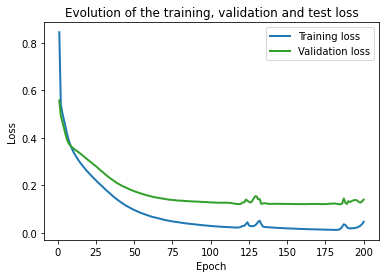

In [58]:
plot_loss(CES_reg.train_loss_history, CES_reg.val_loss_history)

In [59]:
# allowing empty intervals
alpha = 0.1

coverage_CES = []
size_CES = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # find the best models
  best_models = CES_reg.select_model(input)
  # do ICP using the best models
  CESPI = C_PI.CES_icp(input, best_models, method = 'union')
  # compute the size of the prediction interval
  size_single = sum([intv._measure for intv in CESPI])
  # compute the coverage of the prediction interval
  coverage_single = sum([response in intv for intv in CESPI]) > 0
  coverage_CES.append(coverage_single)
  size_CES.append(size_single)
  # print(coverage_single)
  # print(size_single)
  # print('average coverage: {}'.format(sum(coverage_CES)/len(coverage_CES)))
  # print('average size: {}'.format(sum(size_CES)/len(size_CES)))

print('seed {}'.format(seed))
print(sum(coverage_CES)/len(coverage_CES))
print(sum(size_CES)/len(size_CES))

  0%|          | 0/100 [00:00<?, ?it/s]

elapse time (selecting best models):24.502753257751465


  2%|▏         | 2/100 [00:48<39:46, 24.36s/it]

elapse time (selecting best models):23.92698836326599


  3%|▎         | 3/100 [01:13<39:33, 24.47s/it]

elapse time (selecting best models):24.48019313812256


  4%|▍         | 4/100 [01:37<38:43, 24.20s/it]

elapse time (selecting best models):23.72367238998413
elapse time (selecting best models):23.927976846694946


  6%|▌         | 6/100 [02:26<38:21, 24.49s/it]

elapse time (selecting best models):24.89662790298462


  7%|▋         | 7/100 [02:51<38:10, 24.63s/it]

elapse time (selecting best models):24.752416133880615


  8%|▊         | 8/100 [03:15<37:30, 24.46s/it]

elapse time (selecting best models):23.907259225845337


  9%|▉         | 9/100 [03:39<37:04, 24.44s/it]

elapse time (selecting best models):24.227741479873657


 10%|█         | 10/100 [04:04<36:36, 24.40s/it]

elapse time (selecting best models):24.172003269195557
elapse time (selecting best models):24.11321473121643


 11%|█         | 11/100 [04:28<36:11, 24.40s/it]

elapse time (selecting best models):24.18523073196411


 12%|█▏        | 12/100 [04:53<35:47, 24.41s/it]

elapse time (selecting best models):24.02079200744629


 14%|█▍        | 14/100 [05:41<35:03, 24.45s/it]

elapse time (selecting best models):24.449467182159424


 15%|█▌        | 15/100 [06:06<34:44, 24.53s/it]

elapse time (selecting best models):24.604501247406006


 16%|█▌        | 16/100 [06:31<34:20, 24.53s/it]

elapse time (selecting best models):24.414260625839233


 17%|█▋        | 17/100 [06:55<33:54, 24.52s/it]

elapse time (selecting best models):24.315541982650757
elapse time (selecting best models):24.417768001556396


 19%|█▉        | 19/100 [07:44<33:00, 24.46s/it]

elapse time (selecting best models):24.164339065551758


 20%|██        | 20/100 [08:09<32:44, 24.56s/it]

elapse time (selecting best models):24.639827013015747
elapse time (selecting best models):24.694446086883545


 21%|██        | 21/100 [08:34<32:30, 24.68s/it]

elapse time (selecting best models):24.39753246307373


 23%|██▎       | 23/100 [09:23<31:36, 24.64s/it]

elapse time (selecting best models):24.40596914291382


 24%|██▍       | 24/100 [09:47<31:09, 24.60s/it]

elapse time (selecting best models):24.329864025115967


 25%|██▌       | 25/100 [10:12<30:38, 24.51s/it]

elapse time (selecting best models):24.27389931678772
elapse time (selecting best models):24.380237817764282


 26%|██▌       | 26/100 [10:36<30:16, 24.54s/it]

elapse time (selecting best models):24.443968772888184


 27%|██▋       | 27/100 [11:01<29:56, 24.60s/it]

elapse time (selecting best models):23.992445945739746


 29%|██▉       | 29/100 [11:50<28:52, 24.41s/it]

elapse time (selecting best models):24.10011315345764


 30%|███       | 30/100 [12:15<28:42, 24.61s/it]

elapse time (selecting best models):24.981358528137207


 31%|███       | 31/100 [12:40<28:25, 24.72s/it]

elapse time (selecting best models):24.76607322692871


 32%|███▏      | 32/100 [13:04<28:00, 24.72s/it]

elapse time (selecting best models):24.586087226867676
elapse time (selecting best models):24.27868127822876


 34%|███▍      | 34/100 [13:53<26:57, 24.51s/it]

elapse time (selecting best models):23.98800826072693


 35%|███▌      | 35/100 [14:17<26:25, 24.39s/it]

elapse time (selecting best models):24.031550407409668


 36%|███▌      | 36/100 [14:42<26:08, 24.51s/it]

elapse time (selecting best models):24.751052379608154


 37%|███▋      | 37/100 [15:06<25:38, 24.42s/it]

elapse time (selecting best models):24.02620840072632


 38%|███▊      | 38/100 [15:30<25:07, 24.31s/it]

elapse time (selecting best models):24.000014543533325
elapse time (selecting best models):24.290215492248535


 40%|████      | 40/100 [16:19<24:24, 24.41s/it]

elapse time (selecting best models):24.260059356689453


 41%|████      | 41/100 [16:43<23:55, 24.34s/it]

elapse time (selecting best models):24.034814596176147


 42%|████▏     | 42/100 [17:08<23:29, 24.30s/it]

elapse time (selecting best models):24.121254682540894


 43%|████▎     | 43/100 [17:31<22:57, 24.16s/it]

elapse time (selecting best models):23.80374002456665


 44%|████▍     | 44/100 [17:56<22:36, 24.21s/it]

elapse time (selecting best models):24.206573963165283
elapse time (selecting best models):24.228748083114624


 46%|████▌     | 46/100 [18:45<21:51, 24.28s/it]

elapse time (selecting best models):24.14400053024292
elapse time (selecting best models):24.282269716262817


 48%|████▊     | 48/100 [19:34<21:09, 24.41s/it]

elapse time (selecting best models):24.33076286315918


 49%|████▉     | 49/100 [19:59<20:53, 24.57s/it]

elapse time (selecting best models):24.80866575241089
elapse time (selecting best models):24.609957933425903


 51%|█████     | 51/100 [20:48<20:12, 24.75s/it]

elapse time (selecting best models):24.744778156280518


 52%|█████▏    | 52/100 [21:13<19:49, 24.78s/it]

elapse time (selecting best models):24.665689945220947
elapse time (selecting best models):24.24122405052185


 54%|█████▍    | 54/100 [22:02<18:47, 24.51s/it]

elapse time (selecting best models):23.99919319152832
elapse time (selecting best models):23.81133270263672


 55%|█████▌    | 55/100 [22:26<18:16, 24.37s/it]

elapse time (selecting best models):23.788430213928223


 56%|█████▌    | 56/100 [22:50<17:47, 24.26s/it]

elapse time (selecting best models):23.88164734840393


 57%|█████▋    | 57/100 [23:14<17:22, 24.25s/it]

elapse time (selecting best models):23.714996337890625


 59%|█████▉    | 59/100 [24:02<16:28, 24.10s/it]

elapse time (selecting best models):23.78829073905945
elapse time (selecting best models):23.730052709579468


 61%|██████    | 61/100 [24:50<15:35, 24.00s/it]

elapse time (selecting best models):23.653462886810303
elapse time (selecting best models):23.811094522476196


 62%|██████▏   | 62/100 [25:14<15:12, 24.01s/it]

elapse time (selecting best models):24.224207401275635


 64%|██████▍   | 64/100 [26:03<14:36, 24.35s/it]

elapse time (selecting best models):24.6548011302948


 65%|██████▌   | 65/100 [26:27<14:08, 24.25s/it]

elapse time (selecting best models):23.94181728363037


 66%|██████▌   | 66/100 [26:51<13:44, 24.25s/it]

elapse time (selecting best models):24.09352207183838
elapse time (selecting best models):24.035791873931885


 68%|██████▊   | 68/100 [27:40<12:53, 24.18s/it]

elapse time (selecting best models):23.82932758331299


 69%|██████▉   | 69/100 [28:04<12:30, 24.22s/it]

elapse time (selecting best models):24.122825860977173


 70%|███████   | 70/100 [28:28<12:05, 24.18s/it]

elapse time (selecting best models):24.021000862121582
elapse time (selecting best models):23.91539478302002


 71%|███████   | 71/100 [28:52<11:41, 24.18s/it]

elapse time (selecting best models):23.933427333831787


 73%|███████▎  | 73/100 [29:41<10:52, 24.15s/it]

elapse time (selecting best models):24.026337385177612
elapse time (selecting best models):24.230488777160645


 75%|███████▌  | 75/100 [30:29<10:03, 24.14s/it]

elapse time (selecting best models):23.84918451309204
elapse time (selecting best models):24.776118516921997


 77%|███████▋  | 77/100 [31:19<09:23, 24.50s/it]

elapse time (selecting best models):24.685526609420776


 78%|███████▊  | 78/100 [31:43<09:00, 24.57s/it]

elapse time (selecting best models):24.657062530517578
elapse time (selecting best models):25.948398113250732


 79%|███████▉  | 79/100 [32:10<08:46, 25.06s/it]

elapse time (selecting best models):25.32307243347168


 81%|████████  | 81/100 [33:00<07:54, 24.99s/it]

elapse time (selecting best models):24.357651472091675


 82%|████████▏ | 82/100 [33:25<07:29, 24.96s/it]

elapse time (selecting best models):24.731438398361206
elapse time (selecting best models):25.284408807754517


 84%|████████▍ | 84/100 [34:15<06:41, 25.10s/it]

elapse time (selecting best models):24.8868248462677


 85%|████████▌ | 85/100 [34:40<06:16, 25.11s/it]

elapse time (selecting best models):25.007867336273193


 86%|████████▌ | 86/100 [35:05<05:50, 25.04s/it]

elapse time (selecting best models):24.71243453025818
elapse time (selecting best models):24.9071147441864


 87%|████████▋ | 87/100 [35:30<05:26, 25.08s/it]

elapse time (selecting best models):25.42593026161194


 89%|████████▉ | 89/100 [36:21<04:36, 25.15s/it]

elapse time (selecting best models):24.75557017326355


 90%|█████████ | 90/100 [36:46<04:11, 25.13s/it]

elapse time (selecting best models):24.91109347343445
elapse time (selecting best models):24.683347463607788


 91%|█████████ | 91/100 [37:11<03:45, 25.08s/it]

elapse time (selecting best models):24.324782848358154


 93%|█████████▎| 93/100 [38:00<02:53, 24.81s/it]

elapse time (selecting best models):24.375710487365723
elapse time (selecting best models):24.264711618423462


 94%|█████████▍| 94/100 [38:25<02:28, 24.78s/it]

elapse time (selecting best models):24.494967937469482


 95%|█████████▌| 95/100 [38:50<02:03, 24.77s/it]

elapse time (selecting best models):24.106484174728394


 97%|█████████▋| 97/100 [39:38<01:13, 24.51s/it]

elapse time (selecting best models):23.99971103668213


 98%|█████████▊| 98/100 [40:02<00:48, 24.42s/it]

elapse time (selecting best models):24.027642965316772


 99%|█████████▉| 99/100 [40:26<00:24, 24.36s/it]

elapse time (selecting best models):24.01591968536377
elapse time (selecting best models):24.660690307617188


100%|██████████| 100/100 [40:51<00:00, 24.52s/it]

seed 233
0.91
1.33746396950654


In [60]:
# not allowing for empty intervals
alpha = 0.1

coverage_CES = []
size_CES = []

C_PI = Conformal_PI(mod, device, calib_loader, alpha)

for input, response in tqdm(test_loader):
  # find the best models
  best_models = CES_reg.select_model(input)
  # do ICP using the best models
  CESPI = C_PI.CES_icp(input, best_models, method = 'union', no_empty = True, mod = CES_reg)
  # compute the size of the prediction interval
  size_single = sum([intv._measure for intv in CESPI])
  # compute the coverage of the prediction interval
  coverage_single = sum([response in intv for intv in CESPI]) > 0
  coverage_CES.append(coverage_single)
  size_CES.append(size_single)
  # print(coverage_single)
  # print(size_single)
  # print('average coverage: {}'.format(sum(coverage_CES)/len(coverage_CES)))
  # print('average size: {}'.format(sum(size_CES)/len(size_CES)))

print('seed {}'.format(seed))
print(sum(coverage_CES)/len(coverage_CES))
print(sum(size_CES)/len(size_CES))

0it [00:00, ?it/s]

elapse time (selecting best models):24.42138934135437


2it [00:49, 24.56s/it]

elapse time (selecting best models):24.32201313972473


3it [01:13, 24.43s/it]

elapse time (selecting best models):24.149508953094482


4it [01:37, 24.35s/it]

elapse time (selecting best models):24.166152715682983
elapse time (selecting best models):24.31527590751648


6it [02:26, 24.35s/it]

elapse time (selecting best models):24.04364037513733


7it [02:50, 24.30s/it]

elapse time (selecting best models):24.01366400718689


8it [03:14, 24.05s/it]

elapse time (selecting best models):23.363300800323486


9it [03:37, 23.93s/it]

elapse time (selecting best models):23.478981494903564


10it [04:01, 23.86s/it]

elapse time (selecting best models):23.576066255569458
elapse time (selecting best models):23.56976008415222


11it [04:25, 23.86s/it]

elapse time (selecting best models):23.709135055541992


12it [04:49, 23.89s/it]

elapse time (selecting best models):23.939732789993286


14it [05:37, 23.89s/it]

elapse time (selecting best models):23.482287883758545


15it [06:00, 23.77s/it]

elapse time (selecting best models):23.416670322418213


16it [06:24, 23.73s/it]

elapse time (selecting best models):23.530170917510986


17it [06:48, 23.74s/it]

elapse time (selecting best models):23.59208869934082
elapse time (selecting best models):23.486912965774536


19it [07:35, 23.69s/it]

elapse time (selecting best models):23.53239130973816


20it [07:58, 23.63s/it]

elapse time (selecting best models):23.33541440963745
elapse time (selecting best models):23.306163549423218


21it [08:22, 23.62s/it]

elapse time (selecting best models):23.344200134277344


23it [09:09, 23.54s/it]

elapse time (selecting best models):23.282171964645386


24it [09:32, 23.51s/it]

elapse time (selecting best models):23.267483949661255


25it [09:56, 23.54s/it]

elapse time (selecting best models):23.55085849761963
elapse time (selecting best models):23.732519388198853


26it [10:20, 23.67s/it]

elapse time (selecting best models):23.662318468093872


27it [10:44, 23.75s/it]

elapse time (selecting best models):24.043187379837036


29it [11:32, 23.91s/it]

elapse time (selecting best models):23.79392647743225


30it [11:56, 23.81s/it]

elapse time (selecting best models):23.47006583213806
elapse time (selecting best models):23.485605478286743


32it [12:43, 23.69s/it]

elapse time (selecting best models):23.341874837875366
elapse time (selecting best models):23.377331733703613


34it [13:30, 23.63s/it]

elapse time (selecting best models):23.358050107955933


35it [13:53, 23.55s/it]

elapse time (selecting best models):23.287320375442505


36it [14:17, 23.60s/it]

elapse time (selecting best models):23.664689302444458


37it [14:41, 23.59s/it]

elapse time (selecting best models):23.374460220336914


38it [15:04, 23.62s/it]

elapse time (selecting best models):23.652878046035767
elapse time (selecting best models):23.88084101676941


40it [15:52, 23.74s/it]

elapse time (selecting best models):23.47573709487915


41it [16:16, 23.70s/it]

elapse time (selecting best models):23.44873070716858


42it [16:39, 23.67s/it]

elapse time (selecting best models):23.516021490097046


43it [17:03, 23.59s/it]

elapse time (selecting best models):23.336992979049683


44it [17:26, 23.60s/it]

elapse time (selecting best models):23.496173620224
elapse time (selecting best models):23.28065800666809


46it [18:13, 23.52s/it]

elapse time (selecting best models):23.3016517162323
elapse time (selecting best models):23.295066356658936


48it [19:00, 23.51s/it]

elapse time (selecting best models):23.28181481361389


49it [19:24, 23.48s/it]

elapse time (selecting best models):23.27585196495056
elapse time (selecting best models):23.611230850219727


51it [20:11, 23.62s/it]

elapse time (selecting best models):23.49220848083496


52it [20:35, 23.69s/it]

elapse time (selecting best models):23.64350724220276
elapse time (selecting best models):23.928760051727295


54it [21:23, 23.87s/it]

elapse time (selecting best models):23.83857011795044
elapse time (selecting best models):24.012101411819458


55it [21:47, 23.97s/it]

elapse time (selecting best models):23.961899518966675


56it [22:12, 24.04s/it]

elapse time (selecting best models):23.649477243423462


57it [22:36, 24.01s/it]

elapse time (selecting best models):23.788014888763428


59it [23:23, 23.97s/it]

elapse time (selecting best models):23.670955419540405
elapse time (selecting best models):23.84453248977661


61it [24:12, 23.99s/it]

elapse time (selecting best models):23.759474992752075
elapse time (selecting best models):23.883318662643433


62it [24:36, 24.02s/it]

elapse time (selecting best models):23.715240478515625


64it [25:24, 24.09s/it]

elapse time (selecting best models):24.136167526245117


65it [25:48, 24.07s/it]

elapse time (selecting best models):23.961143493652344


66it [26:12, 24.09s/it]

elapse time (selecting best models):23.975937604904175
elapse time (selecting best models):23.851511478424072


67it [26:36, 24.08s/it]

elapse time (selecting best models):23.683390855789185


69it [27:24, 24.01s/it]

elapse time (selecting best models):23.766356945037842


70it [27:48, 23.99s/it]

elapse time (selecting best models):23.900752067565918
0.11996455639600753
./content/model184.pth
avoided empty interval, final pi is [Interval(-2.85826325416565, 3.33703494071960)]
elapse time (selecting best models):24.08921527862549


71it [28:12, 24.11s/it]

elapse time (selecting best models):23.931687116622925


73it [29:00, 24.07s/it]

elapse time (selecting best models):23.87274742126465
elapse time (selecting best models):23.914393663406372


75it [29:49, 24.05s/it]

elapse time (selecting best models):23.905778169631958


76it [30:13, 24.20s/it]

elapse time (selecting best models):24.33964228630066


77it [30:37, 24.19s/it]

elapse time (selecting best models):24.103862524032593


78it [31:02, 24.28s/it]

elapse time (selecting best models):24.44200849533081
elapse time (selecting best models):24.33996033668518


79it [31:26, 24.38s/it]

elapse time (selecting best models):24.21416687965393


81it [32:15, 24.37s/it]

elapse time (selecting best models):24.172157526016235


82it [32:40, 24.41s/it]

elapse time (selecting best models):24.387973308563232
elapse time (selecting best models):24.1908438205719


84it [33:29, 24.46s/it]

elapse time (selecting best models):24.402177810668945


85it [33:53, 24.47s/it]

elapse time (selecting best models):24.353809118270874
0.11996455639600753
./content/model184.pth
avoided empty interval, final pi is [Interval(-2.86087822914124, 3.33441996574402)]


86it [34:18, 24.45s/it]

elapse time (selecting best models):24.269078969955444
elapse time (selecting best models):24.11678123474121


88it [35:06, 24.39s/it]

elapse time (selecting best models):24.105542182922363


89it [35:31, 24.45s/it]

elapse time (selecting best models):24.453436851501465


90it [35:55, 24.39s/it]

elapse time (selecting best models):24.089346885681152
elapse time (selecting best models):24.62543559074402


91it [36:20, 24.54s/it]

elapse time (selecting best models):24.354917526245117


93it [37:08, 24.33s/it]

elapse time (selecting best models):23.63493013381958
elapse time (selecting best models):23.56989336013794


94it [37:32, 24.23s/it]

elapse time (selecting best models):23.53272581100464


95it [37:56, 24.10s/it]

elapse time (selecting best models):23.517109155654907


96it [38:20, 24.00s/it]

elapse time (selecting best models):23.325227737426758


98it [39:07, 23.80s/it]

elapse time (selecting best models):23.470550775527954


99it [39:31, 23.75s/it]

elapse time (selecting best models):23.467724084854126


100it [39:54, 23.95s/it]

elapse time (selecting best models):23.548448085784912
seed 233
0.93
1.46136993340425
